In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from method import IV
from simulator import Simulator
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from exana.statistics import plot_xcorr, permutation_resampling
from tools import savefig, fix_figure, coef_var, corrcoef, despine, set_style
import copy
from IPython.display import display
import statsmodels.api as sm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def model(x):
    return 1/(1+np.exp(-x))

def norm(x):
#     return (x - np.mean(x)) / np.std(x)
    return (x - min(x)) / (max(x) - min(x))

def mean_square_error(x1, x2, norm=None):
    if norm is not None:
        x1, x2 = norm(x1), norm(x2)
    return np.sum((x1 - x2)**2) / len(x1)

In [25]:
trials = [5000, 10000, 15000, 20000, 25000, 30000]
sim_id = [1, 2, 3]
# TOL = -np.inf
# txt = '_neg'
TOL = 0
txt = '_pos'
save = True
set_style('article')

In [6]:
mse = {}
for sid in sim_id:
    tmp = []
    for N_trials in trials:
        analys = pd.read_csv('results/orig_analysis/params_{}_analyse_{}.csv'.format(sid, N_trials))
        cut = analys.loc[analys.wald > TOL, ['wald', 'weight']] # analys.wald > 0
        case, control = cut['wald'], cut['weight']
        tmp.append(mean_square_error(case, control, norm=norm))
    mse[sid] = {'mse': tmp}

In [9]:
mse_cch = {}
for sid in sim_id:
    tmp = []
    for N_trials in trials:
        analys = pd.read_csv('results/orig_analysis/params_{}_analyse_{}.csv'.format(sid, N_trials))
        analys['cch'] = analys['trans_prob']
        analys.loc[(analys.pfast > 0.001) & (analys.pcausal > 0.001),'cch'] = np.nan
        cut = analys.loc[analys.cch > TOL, ['cch', 'weight']] # analys.cch > 0
        case, control = cut['cch'], cut['weight']
        tmp.append(mean_square_error(case, control, norm=norm))
    mse_cch[sid] = {'mse': tmp}

$g$ = 9.9 = -0.77
$g$ = 4.4 = -0.48
$g$ = 3.0 = -0.40


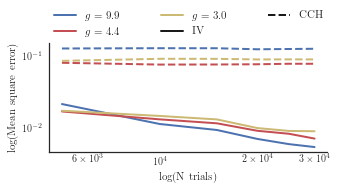

In [26]:
legend = {
    1: '$g$ = 9.9',
    2: '$g$ = 4.4',
    3: '$g$ = 3.0'
}
color = {
    1: 'b',
    2: 'r',
    3: 'y'
}
h = []
for sid in sim_id:
    slope, intercept = np.polyfit(np.log(trials), np.log(mse[sid]['mse']), 1)
    print('{} = {:.2f}'.format(legend[sid], slope))
    a, = plt.loglog(trials, mse[sid]['mse'], label=legend[sid], color=color[sid])
    plt.loglog(trials, mse_cch[sid]['mse'], ls='--', color=color[sid])
    h.append(a)
despine()

import matplotlib.lines as mlines

iv = mlines.Line2D([], [], color='k', ls='-', label='IV')
cch = mlines.Line2D([], [], color='k', ls='--', label='CCH')
h.extend([iv,cch])
plt.legend(handles=h, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
plt.xlabel('log(N trials)')
plt.ylabel('log(Mean square error)')
if save: savefig(plt.gcf(), 'mse{}'.format(txt), bbox_inches='tight')

In [17]:
analys['logit'] = model(analys.logreg + analys.logreg_intercept)

analys.loc[analys['wald'] < 0,'wald'] = 0

analys['cch'] = analys['trans_prob']
analys.loc[analys['cch'] < 0,'cch'] = 0


# analys.loc[(analys.pfast > 0.001) & (analys.pcausal > 0.001),'cch'] = np.nan

In [18]:
analys['weight'] = norm(analys['weight'])
analys['logit'] = norm(analys['logit'])
analys['wald'] = norm(analys['wald'])
analys['cch'] = norm(analys['cch'])

In [19]:
sum(analys.pcausal < 0.001)

330

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff97276fd0>,
      dtype=object)

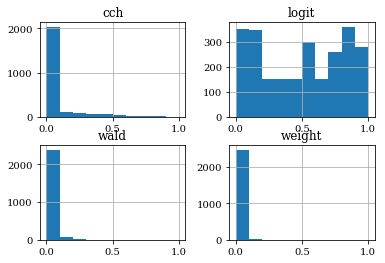

In [20]:
analys.loc[:, ['cch', 'logit', 'wald', 'weight']].hist()